# Chromosome ideograms

In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import geneinfo as gi
gi.email('your@email.com')

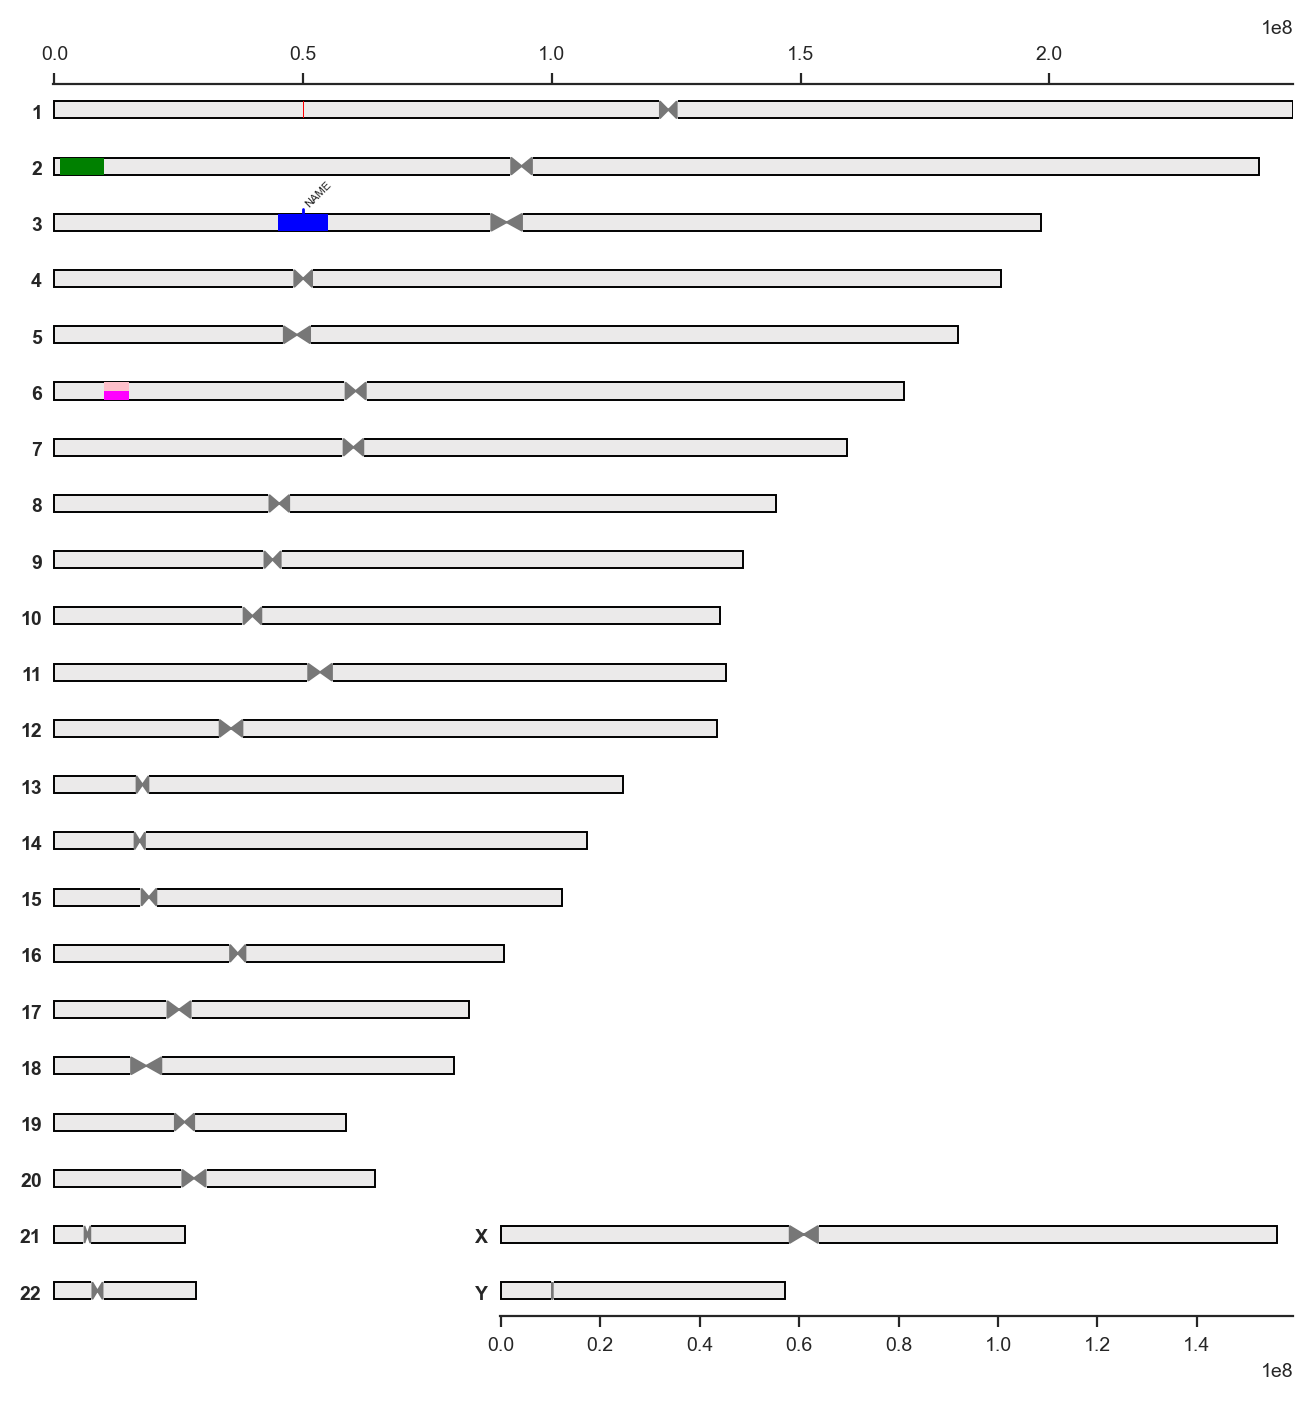

In [48]:
annotation = [
    ('chr1', 50000000, 50001000),                          # segment color defaults to red
    ('chr2', 10000000, 1000000, 'green'),                  # with segment color
    ('chr3', 45000000, 55000000, 'blue', 'NAME'),          # with name label
    ('chr6', 10000000, 15000000, 'magenta', None, 0, 0.5), # with base and height
    ('chr6', 10000000, 15000000, 'pink', None, 0.5, 0.5),  # with base and height
]

gi.chrom_ideogram(annotation, figsize=(8, 8))

To make sure segments are visible on the plot, the default minimal size of plotteed segments are 200000. This can be changed like this (notice how the chr1 segment is no longer visible):

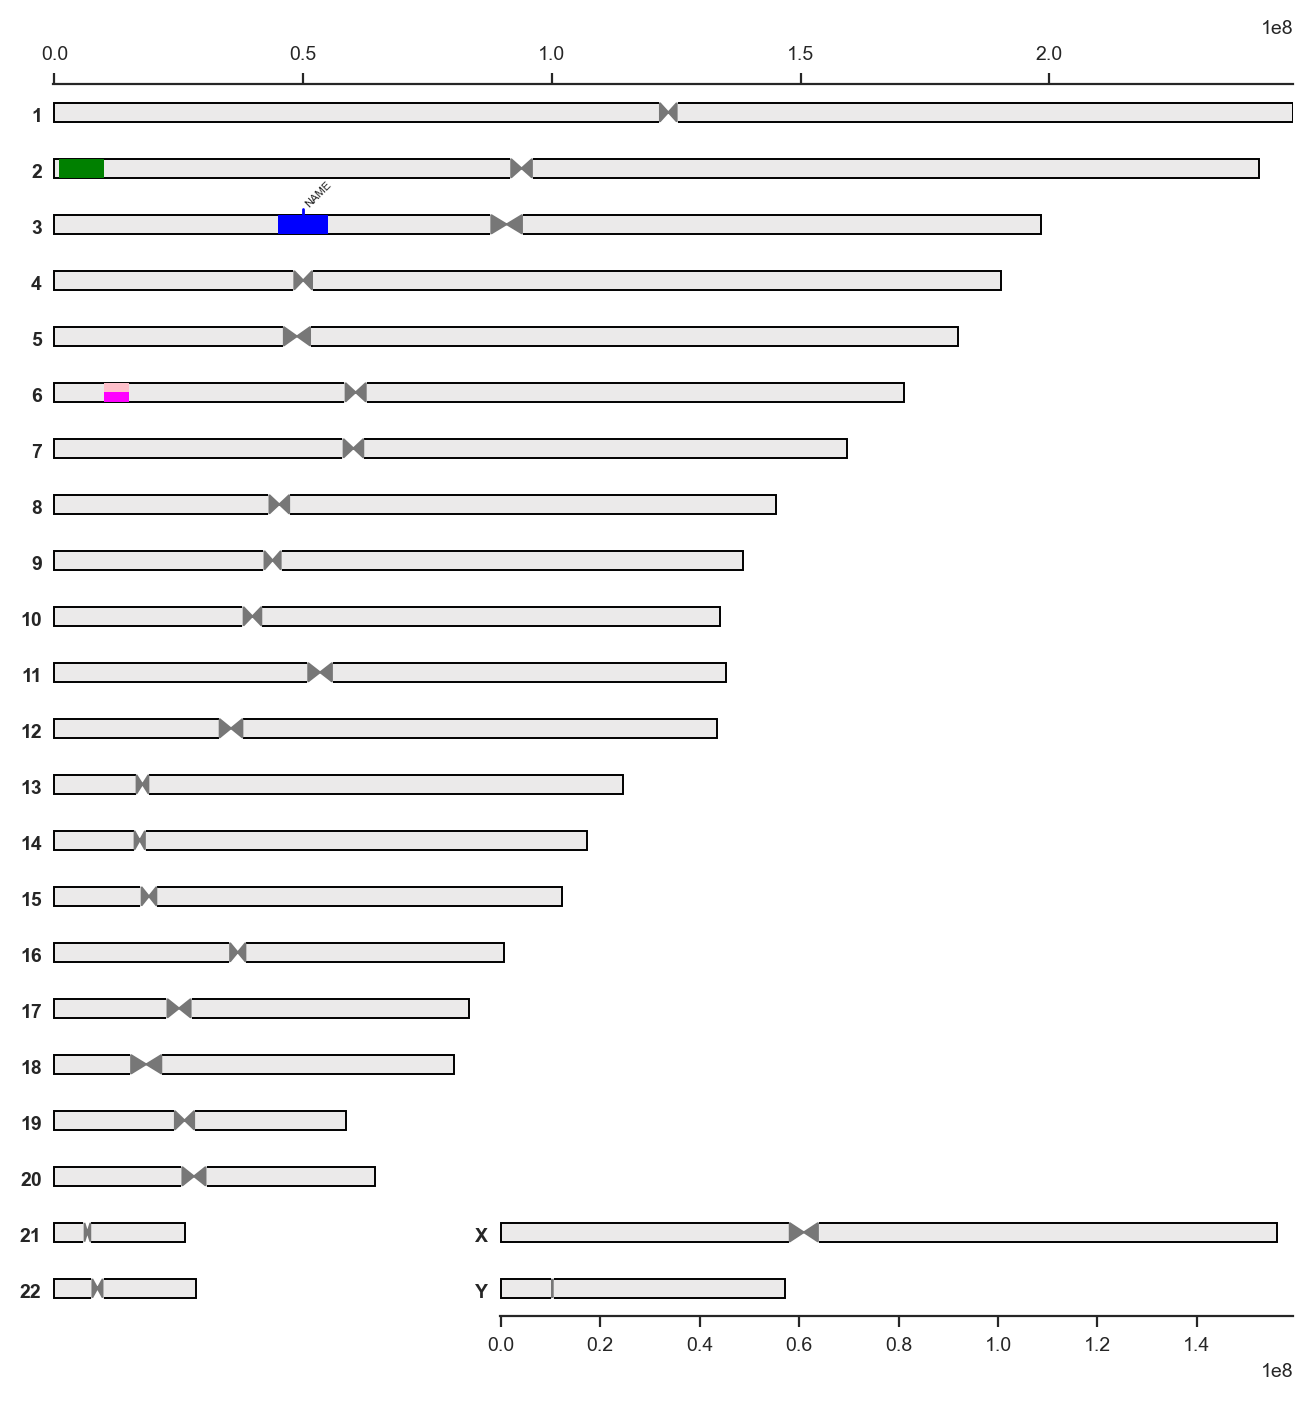

In [49]:
gi.chrom_ideogram(annotation, figsize=(8, 8), min_visible_width=1, hspace=0)

Other assembly, figure dimentions:

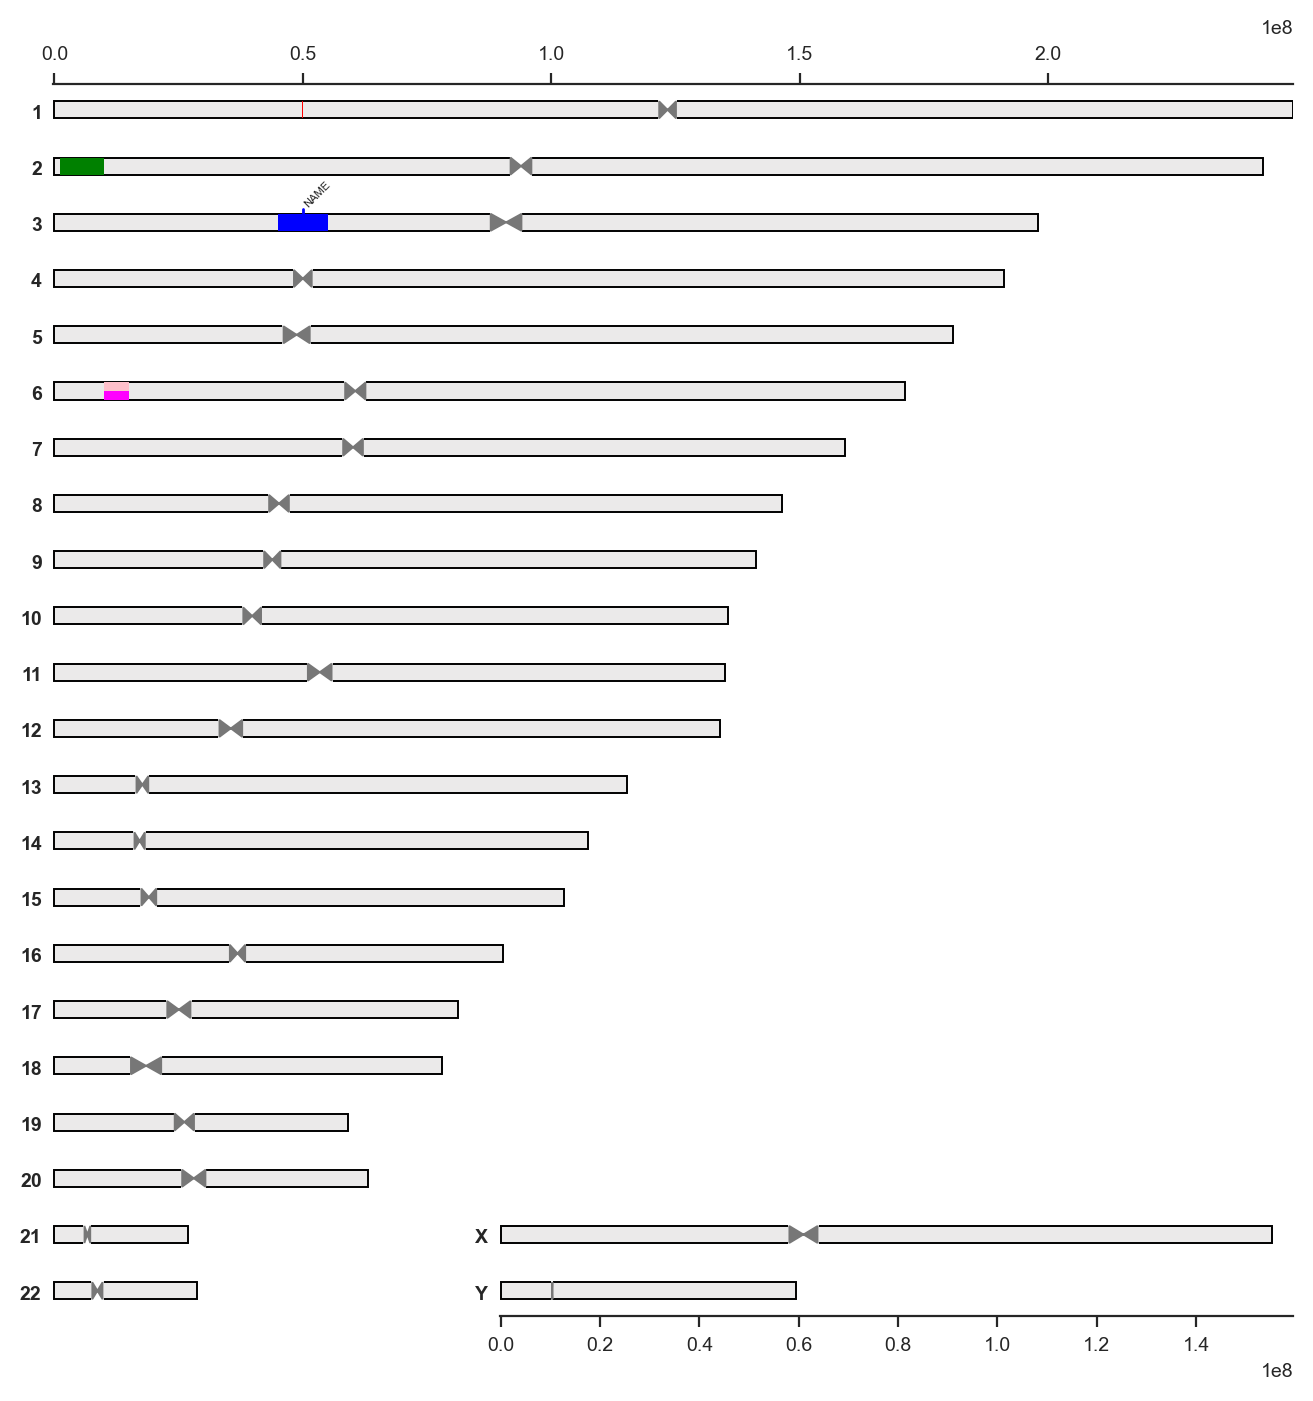

In [50]:
gi.chrom_ideogram(annotation, assembly='hg19', figsize=(8, 8))

**You can add position markers along a chromosome like this to better see the location of some segments:**

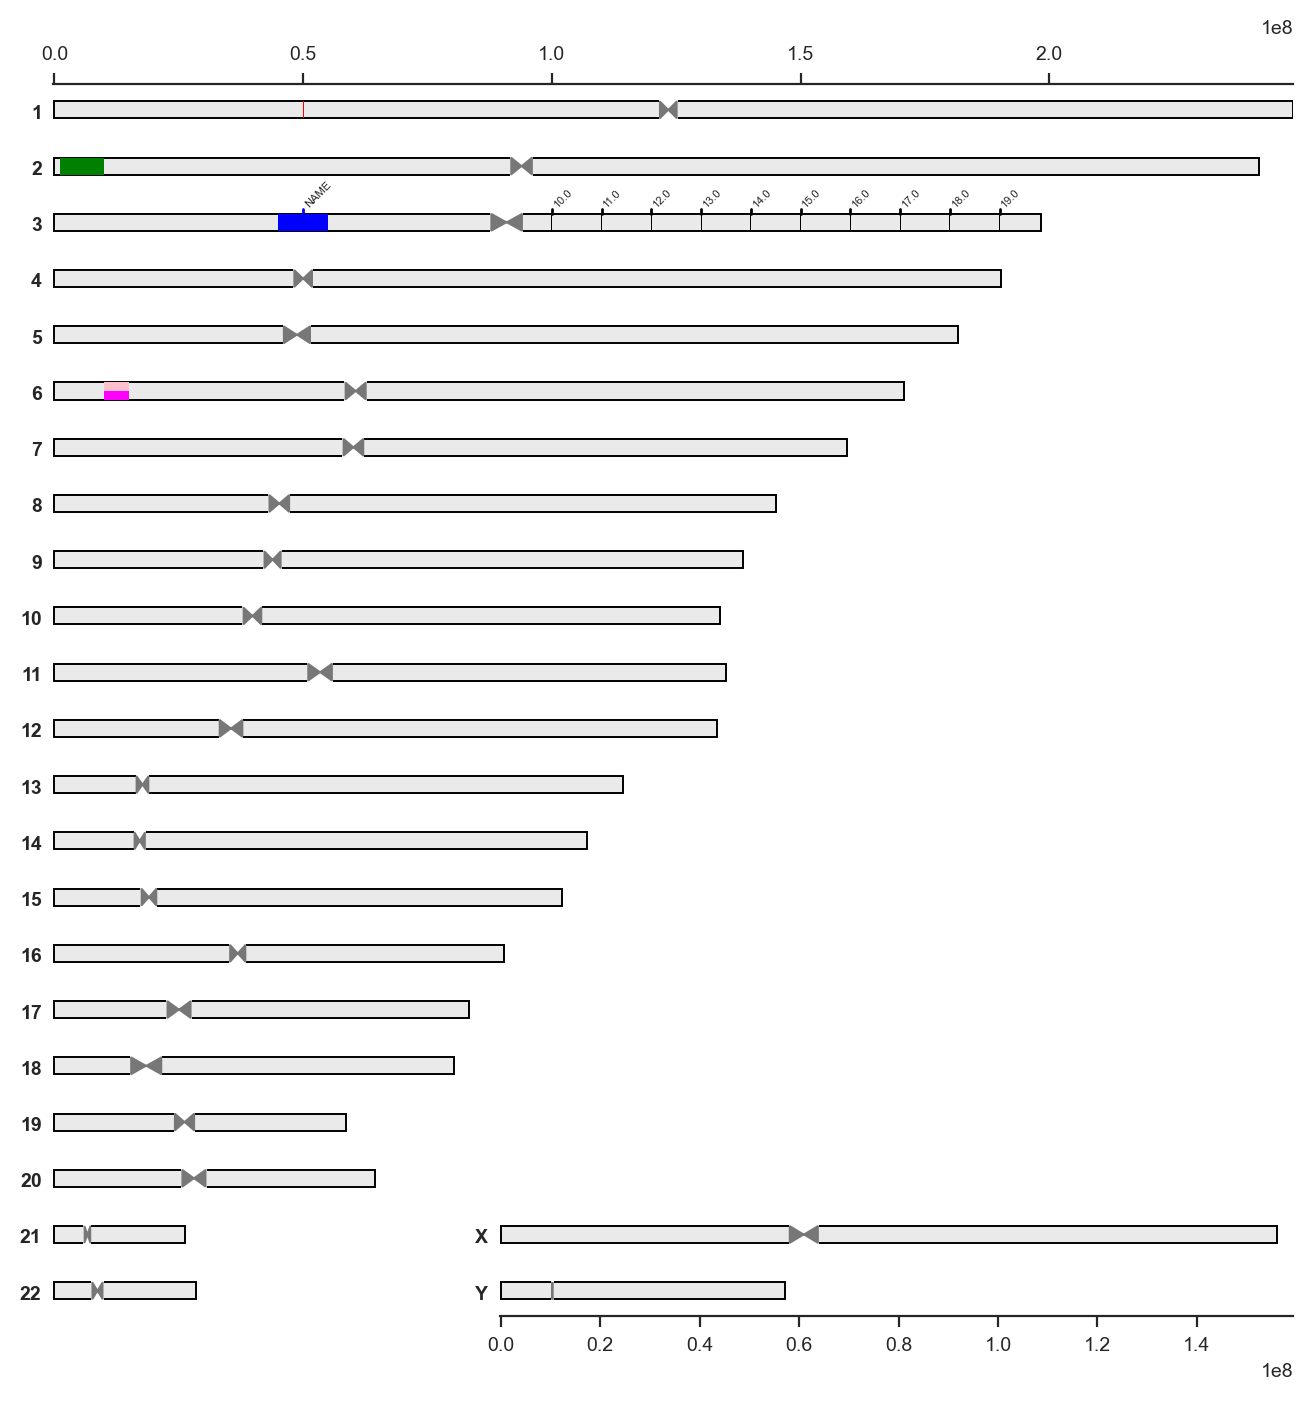

In [51]:
chrom = 'chr3'
start = 100000000
end = 200000000
width = 10000000
annotation2 = annotation + [(chrom, x[0], x[1], 'black', str(x[2]/width)) for x in zip(
    range(start, end, width), 
    range(start+1, end, width), 
    range(start, end, width)
)]
gi.chrom_ideogram(annotation2, figsize=(8, 8))

In [4]:
lists = gi.GoogleSheet()

In [16]:
import importlib
import geneinfo
importlib.reload(geneinfo)

coords = gi.gene_coord(lists.get('xi_escape'), assembly='GRCh38')
annotation = [(c, s, e, 'red', g) for g, (c, s, e, _) in coords.items()]

In [5]:
coords = gi.gene_coord(['ATRX', 'MAGT1'], assembly='GRCh38')
annotation = [(c, s, e, 'red', g) for g, (c, s, e, _) in coords.items()]

In [713]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Polygon:
    def __init__(self, points):
        self.points = points

    def get_points(self):
        return self.points

    def nudge_y(self, nudge):
        for point in self.points:
            point.y += nudge

def is_polygons_intersecting(a, b):
    for x in range(2):
        polygon = a if x == 0 else b

        for i1 in range(len(polygon.get_points())):
            i2 = (i1 + 1) % len(polygon.get_points())
            p1 = polygon.get_points()[i1]
            p2 = polygon.get_points()[i2]

            normal = Point(p2.y - p1.y, p1.x - p2.x)

            min_a = float('inf')
            max_a = float('-inf')

            for p in a.get_points():
                projected = normal.x * p.x + normal.y * p.y
                min_a = min(min_a, projected)
                max_a = max(max_a, projected)

            min_b = float('inf')
            max_b = float('-inf')

            for p in b.get_points():
                projected = normal.x * p.x + normal.y * p.y
                min_b = min(min_b, projected)
                max_b = max(max_b, projected)

            if max_a < min_b or max_b < min_a:
                return False

    return True

a = list(zip([0, 0, 2, 2], [0, 2, 2, 0]))
b = list(zip([1, 1, 3, 3], [1, 3, 3, 1]))

is_polygons_intersecting(
    Polygon([Point(*tup) for tup in a]),
    Polygon([Point(*tup) for tup in b])
)

True

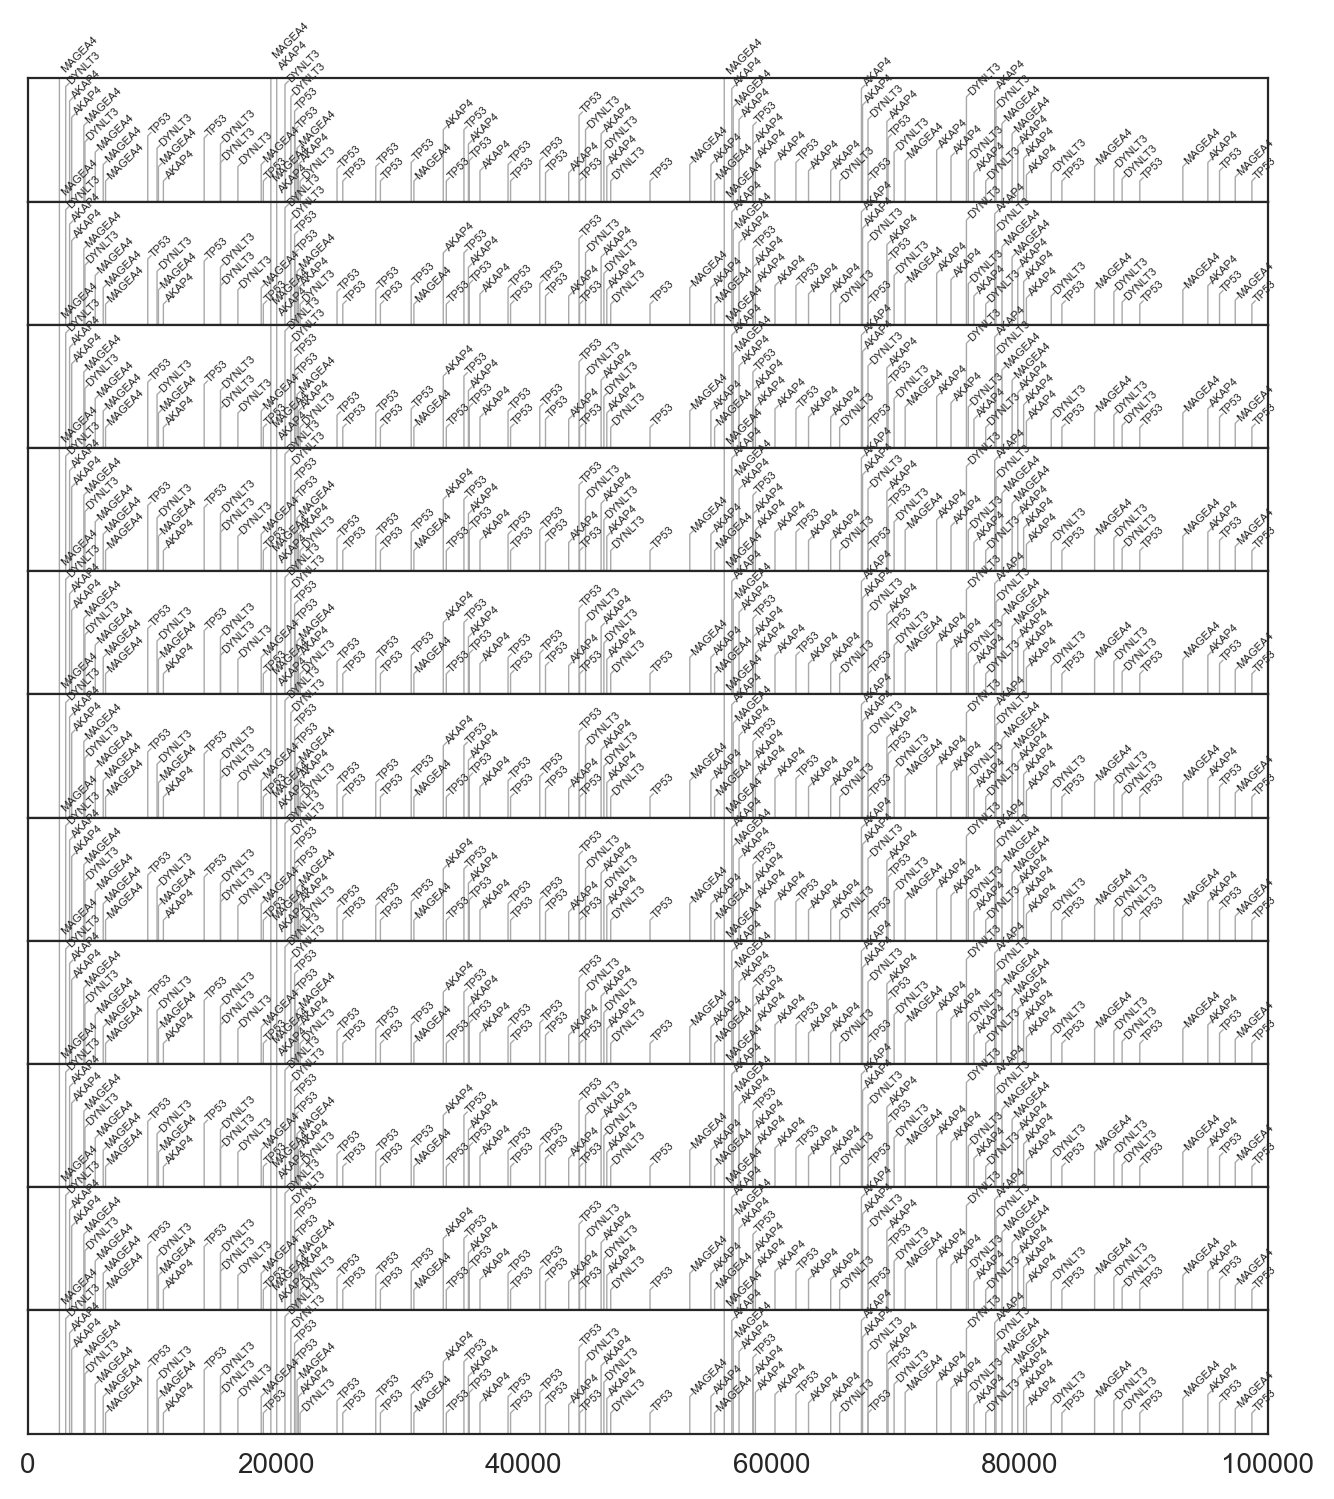

In [827]:
import pandas as pd
import math
from matplotlib.artist import Artist


axes_height = 1e4 # relative to length of chrom one
max_chrom_size = 1e5
aspect = axes_height / chrom_size

fig_width_inches = 8
axes_height_inches = fig_width * aspect
fig_height = axes_height_inches * nr_rows

nr_rows = 11
fig, axes = plt.subplots(nr_rows, 1, figsize=(fig_width, fig_width*aspect*nr_rows), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0)
ax = axes[0]

xlim = (0, max_chrom_size)
ylim = (0, 6)
scaled_y_lim = xlim[0] * aspect, xlim[1] * aspect
ax.set_xlim(xlim)
ax.set_ylim(scaled_y_lim)
plt.yticks([])
y_unit = -sub(*scaled_y_lim) / -sub(*ylim)

rel_font_height = 0.07
font_size = rel_font_height * axes_height_inches / point_size


def draw_text(x_pos, y_pos, text, font_size, ax, y_line_bottom=0):
 
    t = ax.text(x_pos, y_pos, text, fontsize=font_size, 
                horizontalalignment='left',
                verticalalignment='bottom', 
                rotation=45, zorder=3, 
                bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
    # t.set_bbox(dict(facecolor='red', pad=0, alpha=0.2, edgecolor='none'))
    ax.plot((x_pos, x_pos, x_pos+y_unit/6),
            (y_line_bottom, y_pos, y_pos+y_unit/6), 
            linewidth=0.5, color='darkgray', zorder=2)


def get_polygon(text:str, x_pos:int, y_pos:float, ax:matplotlib.axes.Axes) -> Polygon:

    y_pos = y_pos * y_unit
    
    t = ax.text(x_pos, y_pos, text, fontsize=font_size, 
                horizontalalignment='left',
                verticalalignment='bottom', 
                rotation=0, zorder=3, 
                # bbox=dict(boxstyle='square,pad=0', 
                bbox=dict(boxstyle='square', 
                          fc='none', ec='none', alpha=0.4))
    
    transf = ax.transData.inverted()
    bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
    bbt = bb.transformed(transf)
    coords = bbt.get_points()
    
    Artist.remove(t)
    
    (x0, y0), (x1, y1) = coords
    pad = (y1 - y0)/5
    coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
        
    x, y = zip(*coords)
    df = pd.DataFrame(dict(x=x, y=y))
    df['y'] -= y_pos
    df['x'] -= x_pos
    dfx = df['x']*math.cos(math.radians(45))-df['y']*math.sin(math.radians(45))
    df['y'] = df['x']*math.sin(math.radians(45))+df['y']*math.cos(math.radians(45))
    df['x'] = dfx
    df['y'] += y_pos
    df['x'] += x_pos
        
    coords = np.array(list(zip(df.x, df.y)))
    
    x_pos, y_pos = df['x'][0] - (df['x'][0] - df['x'][1]), df['y'][0]

    df['x'] = df.x + np.array([-pad, -pad, pad, pad])
    df['y'] = df.y + np.array([-pad, pad, pad, -pad])
    
    return x_pos, y_pos, Polygon([Point(x, y) for x, y in zip(df.x, df.y)])



# annot = [(x, 'AKAP4') for x in range(1, int(max_chrom_size), int(max_chrom_size/100))]

import random
_names = random.choices(['AKAP4', 'DYNLT3', 'MAGEA4', 'TP53'], k=100)
_pos = np.random.randint(1, max_chrom_size, 100).tolist()
annot = list(zip(_pos, _names))
#annot = [(x, 'AKAP4') for x in np.random.randint(1, max_chrom_size, 100).tolist()]

annot = sorted(annot, reverse=True)

for ax in axes:
    polybuff = []
    for pos, name in annot:
        x, y, poly = get_polygon(name, pos, 1, ax)

        while any(is_polygons_intersecting(poly, p) for p in polybuff):
            nudge = 0.1 * y_unit
            y += nudge
            poly.nudge_y(nudge)
        draw_text(x, y, name, font_size, ax)

        if len(polybuff) > 5:
            del polybuff[0]
        polybuff.append(poly)

    z = 10
    for i, t in enumerate(reversed(ax.texts)):
        t.set_zorder(z+i)


# text = 'Tester'
# x, y, poly = get_polygon(text, chrom_size/2, 2, ax)
# nudge = -1 * y_unit
# y += nudge
# poly.nudge_y(nudge)
# draw_text(x, y, text, font_size, ax)


# text = 'AKAP4'
# x, y, poly = get_polygon(text, chrom_size/2, 2, axes[1])
# nudge = +1 * y_unit
# y += nudge
# poly.nudge_y(nudge)
# draw_text(x, y, text, font_size, axes[1])


In [799]:
# import pandas as pd
# import math
# from matplotlib.artist import Artist


# axes_height = 1e4 # relative to length of chrom one
# max_chrom_size = 1e5
# aspect = axes_height / chrom_size

# fig_width_inches = 8
# axes_height_inches = fig_width * aspect
# fig_height = axes_height_inches * nr_rows

# nr_rows = 11
# fig, axes = plt.subplots(nr_rows, 1, figsize=(fig_width, fig_width*aspect*nr_rows), sharex=True, sharey=True)
# plt.subplots_adjust(hspace=0)
# ax = axes[0]

# xlim = (0, max_chrom_size)
# ylim = (0, 6)
# scaled_y_lim = xlim[0] * aspect, xlim[1] * aspect
# ax.set_xlim(xlim)
# ax.set_ylim(scaled_y_lim)
# plt.yticks([])
# y_unit = -sub(*scaled_y_lim) / -sub(*ylim)

# rel_font_height = 0.1
# font_size = rel_font_height * axes_height_inches / point_size


# def draw_text(x_pos, y_pos, text, font_size, rel_font_height, ax, y_line_bottom=0):
 
#     ax.text(x_pos, y_pos, 'Tester', fontsize=font_size, 
#                 horizontalalignment='left',# weight='bold',
#                 verticalalignment='bottom', 
#                 rotation=45, zorder=3, 
#                 bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
#     (_, a), (_, b) = ax.transAxes.transform([(0, 0), (0, rel_font_height / 2)])
#     z = b - a    
#     z = 300
#     z = y_unit/6

#     ax.plot((x_pos, x_pos, x_pos+z),
#             (y_line_bottom, y_pos, y_pos+z), 
#             linewidth=0.5, color='gray')


# def get_polygon(text:str, x_pos:int, y_pos:float, font_size:float, ax:matplotlib.axes.Axes) -> Polygon:

#     y_pos = y_pos * y_unit
#     # x_pos, y_pos = chrom_size/2, 2*y_unit
    
#     # ax.scatter([x_pos], [y_pos], marker='X', color='black')
    
    
#     t = ax.text(x_pos, y_pos, 'Tester', fontsize=font_size, 
#                 horizontalalignment='left',# weight='bold',
#                 verticalalignment='bottom', 
#                 rotation=0, zorder=3, 
#                 bbox=dict(boxstyle='square,pad=0', fc='none', ec='none', alpha=0.4))
#     # t.set_visible(False)
    
#     transf = ax.transData.inverted()
#     bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
#     bbt = bb.transformed(transf)
#     coords = bbt.get_points()
    
#     Artist.remove(t)
    
#     (x0, y0), (x1, y1) = coords
#     coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
#     # ax.scatter(*coords.T, c='red')
    
#     # ax.scatter(*zip(*coords), transform=ax.transAxes, s=1, color='green', zorder=3)
    
#     x, y = zip(*coords)
#     df = pd.DataFrame(dict(x=x, y=y))
#     df['y'] -= y_pos
#     df['x'] -= x_pos
#     dfx = df['x']*math.cos(math.radians(45))-df['y']*math.sin(math.radians(45))
#     df['y'] = df['x']*math.sin(math.radians(45))+df['y']*math.cos(math.radians(45))
#     df['x'] = dfx
#     df['y'] += y_pos
#     df['x'] += x_pos
    
#     #df['x'] -= df['x'][1] - df['x'][0]
    
#     coords = np.array(list(zip(df.x, df.y)))
    
#     x_pos, y_pos = df['x'][0] - (df['x'][0] - df['x'][1]), df['y'][0]
#     # _ = ax.text(x_pos, y_pos, 'Tester', fontsize=font_size, 
#     #             horizontalalignment='left',# weight='bold',
#     #             verticalalignment='bottom', 
#     #             rotation=45, zorder=3, 
#     #             bbox=dict(boxstyle='square,pad=0', fc='none', ec='none'))
    
#     # ax.scatter(*coords.T, c='blue')
    
#     # ax.plot(*zip(*coords), linewidth=0.2)

#     return x_pos, y_pos, Polygon([Point(x, y) for x, y in zip(df.x, df.y)])


# annot = [(x, 'AKAP4') for x in range(1, int(max_chrom_size), int(max_chrom_size/200))]

# for i, ax in enumerate(axes):
#     annot = [(x, 'AKAP4') for x in range(1, int(max_chrom_size), int(max_chrom_size/(10*(i+1))))]

#     polybuff = []
#     for pos, name in annot:
#         x, y, poly = get_polygon(name, pos, 1, rel_font_height, ax)

#         while any(is_polygons_intersecting(poly, p) for p in polybuff):
#             nudge = 0.1 * y_unit
#             y += nudge
#             poly.nudge_y(nudge)
#         draw_text(x, y, name, font_size, rel_font_height, ax)

#         if len(polybuff) > 5:
#             del polybuff[0]
#         polybuff.append(poly)


[[0.2        0.2       ]
 [0.27711694 0.30281385]]
[[0.51148154 0.92042049]
 [0.55200529 0.73124667]
 [0.6914605  0.9821989 ]
 [0.65093675 1.17137271]]
1.3419913419913418


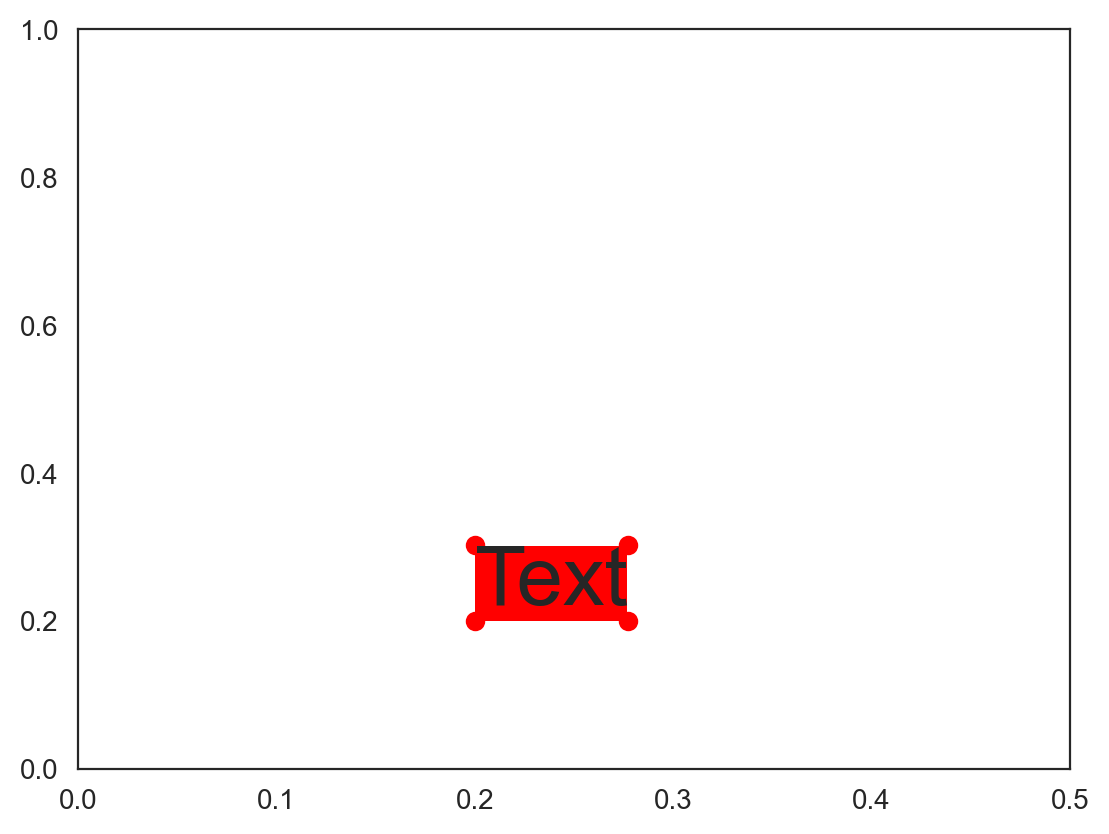

In [559]:
import matplotlib.transforms

from matplotlib.transforms import Bbox
fig, ax = plt.subplots()
plt.xlim(0, 0.5)
plt.ylim(0, 1)

t = ax.text(0.2, 0.2, 'Text', fontsize=30, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))
transf = ax.transData.inverted()
bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
bbt = bb.transformed(transf)
coords = bbt.get_points()
print(coords)
(x0, y0), (x1, y1) = coords
plt_coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])

ax.scatter(*plt_coords.T, c='red')


from operator import sub
aspect_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

#x0, y0 = coords[0]
# (x0, y0), (x1, y2) = coords
trafo = matplotlib.transforms.Affine2D().rotate_deg_around(x0,y0,45).skew(1, 1.3)#.scale(0.5)

coords = trafo.transform([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
# coords = trafo.transform([(x0, y0), (x1, y1)])
# coords = trafo.transform(coords)
print(coords)

ax.scatter(*coords.T, zorder=10)

disp_ratio = ax.get_data_ratio()
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
disp_ratio = bbox.width / bbox.height
print(disp_ratio)



(x0, y0), (x0, y1), (x1, y1), (x1, y0) = coords
coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])

ax.scatter(*coords.T)


Polygon([Point(x0, y0), Point(bbt.xmin, b[1]+(b[0]-bbt.xmin)), Point(b[2], b[3]), Point(bbt.xmax, b[3]-(b[0]-bbt.xmin))])


#Bbox.count_overlaps

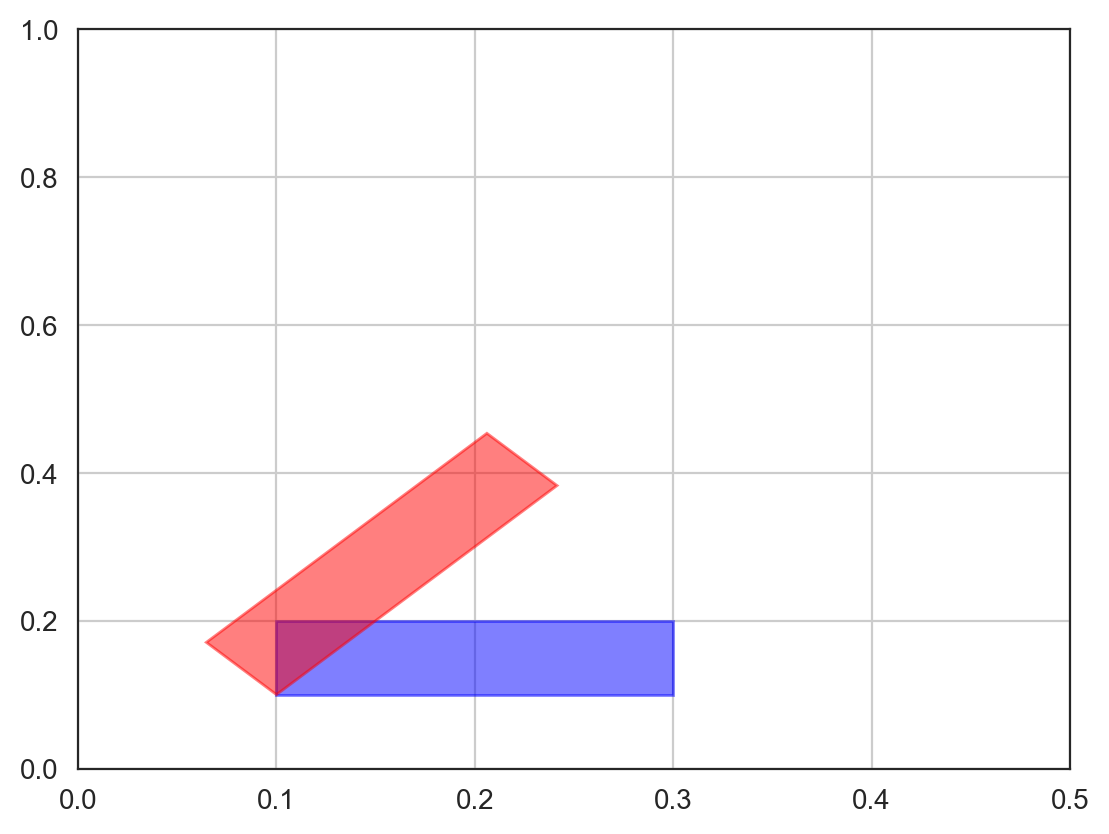

In [560]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as transforms

fig, ax = plt.subplots()

# [[0.25574077 0.46021024]
#  [0.29626452 0.27103643]
#  [0.43571973 0.52198865]
#  [0.39519598 0.71116247]]

# [[0.1        0.1       ]
#  [0.17711694 0.20281385]]
r1 = patches.Rectangle((0.1, 0.1), 0.2, 0.1, color="blue", alpha=0.5)
r2 = patches.Rectangle((0.1, 0.1), 0.2, 0.1, color="red", alpha=0.5)


p = 0.1, 0.1 # rotate around this point

x_lim = (0, 0.5)
y_lim = (0, 1)
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

x_range = x_lim[1] - x_lim[0]
y_range = y_lim[1] - y_lim[0]
aspect_ratio = y_range / x_range

move_transform = transforms.Affine2D().translate(-p[0], -p[1])
inverse_move_transform = transforms.Affine2D().translate(p[0], p[1])
inverse_scale_transform = transforms.Affine2D().scale(1, 1 / aspect_ratio)
rotate_transform = transforms.Affine2D().rotate_deg(45)
scale_transform = transforms.Affine2D().scale(1, aspect_ratio)

total_transform = move_transform + inverse_scale_transform + rotate_transform + scale_transform + inverse_move_transform + ax.transData

r2.set_transform(total_transform)

ax.add_patch(r1)
ax.add_patch(r2)

# print(ax.transLimits.transform([(0.1, 0.1), (0.1, 0.2), (0.3, 0.2), (0.3, 0.1)]))
# print(total_transform.transform([(0.1, 0.1), (0.1, 0.2), (0.3, 0.2), (0.3, 0.1)]))
# print(r2.get_bbox())
# x0, y0, width, height = r2.get_bbox().bounds()
# print(x0, y0)
# coords = [(x0, y0), 
#           (x0 - sqrt(height**2 / 2), y0 + sqrt(height**2 / 2)), 
#           (x0 - sqrt(height**2 / 2) + sqrt(width**2 / 2), y0 + sqrt(height**2 / 2)) +  + sqrt(width**2 / 2), 
#           (x0 + sqrt(width**2 / 2), y0 + sqrt(width**2 / 2))]
# plt.scatter(*zip(*coords))

# coords = ((0.1, 0.1), (0.1, 0.2), (0.3, 0.2), (0.3, 0.1))
# plt.scatter(*zip(*coords))
# coords = total_transform.transform(coords)
# print(coords)
# plt.scatter(*zip(*coords))

plt.grid(True)
plt.show()

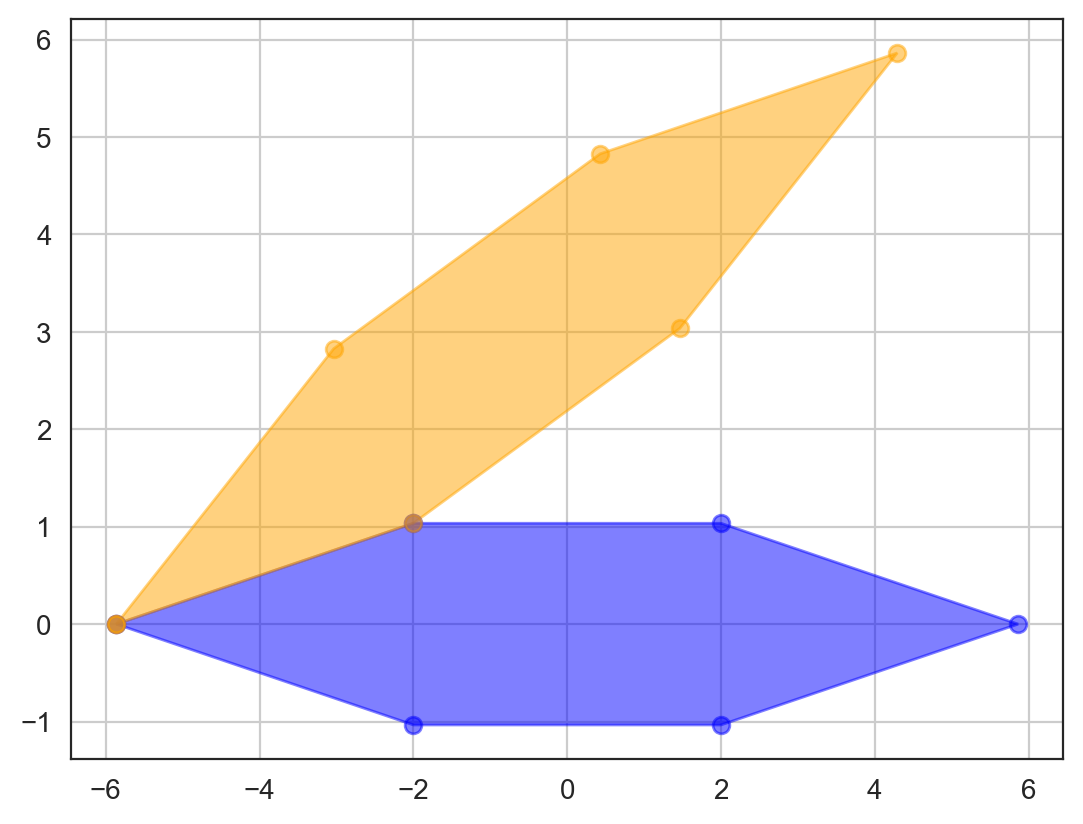

In [365]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from math import *

#some helper values
p=4
theta=pi/6
x1 = p*cos(theta/2)
y1 = p*sin(theta/2)
vertices =[(-x1-p/2,0), (-p/2, y1), (p/2, y1), (x1+p/2, 0), (p/2, -y1), (-p/2, -y1)] 
midPoint = [3,4]
endPoint = (-x1-p/2,0)

#set up the plot
fig = plt.figure()
ax = fig.add_subplot(111)

#function to rotate and translate the standard shape to a new position
def plot_polygon(vertices, midPoint, theta, color):
    polygon = patches.Polygon(vertices, color=color, alpha=0.50) 
    r = mpl.transforms.Affine2D().rotate_around(midPoint[0],midPoint[1], theta)
    # t = mpl.transforms.Affine2D().translate(midPoint[0],midPoint[1])
    tra = r + ax.transData
    # r = mpl.transforms.Affine2D().rotate(theta)
    # t = mpl.transforms.Affine2D().translate(midPoint[0],midPoint[1])
    # tra = r + t + ax.transData
    polygon.set_transform(tra)
    ax.add_patch(polygon)

    return r.transform(polygon.xy)

p = plot_polygon(vertices, endPoint, 0, "blue")
#plot_polygon(vertices, midPoint, theta, "blue")
p_ = plot_polygon(vertices, endPoint, theta, "orange")

# print(p.get_xy())
# print(p_.get_xy())
# print(p.get_transform().transform(p.xy))
# print(p_.get_transform().transform(p_.xy))
#The correct answer is: tra.transform(poly.xy)


plt.scatter(*zip(*p), color='blue', alpha=0.5)
plt.scatter(*zip(*p_), color='orange', alpha=0.5)

# plt.xlim(-10, 10)
# plt.ylim(-10, 10)

plt.grid(True)

plt.show()

In [596]:
chrom_size = 12e5
ylim = (0, 3)
xlim = (0, chrom_size)
data_height = (ylim[1] - ylim[0])
data_width = (xlim[1] - xlim[0])
aspect = data_height / data_width
aspect
# data_width * aspect
# ylim = ylim * sub(*ylim) / sub(*xlim)
# chrom_size * sub(*ylim) / sub(*xlim)

2.5e-06

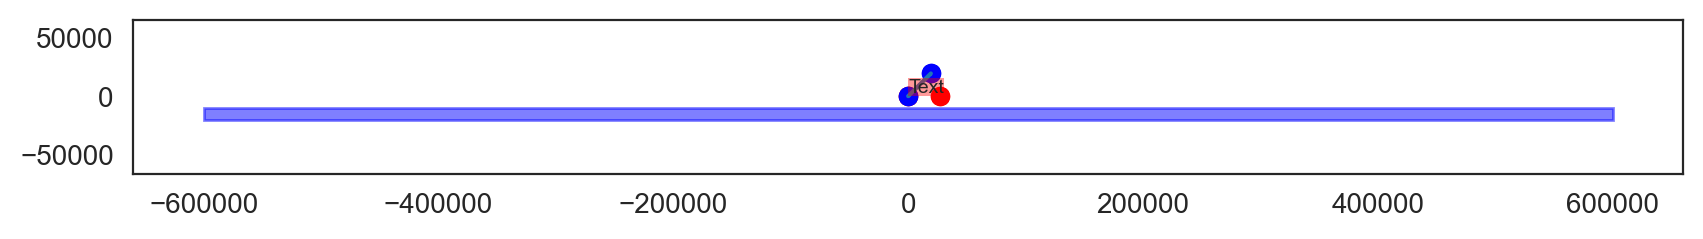

In [586]:
import pandas as pd
import math
from operator import sub
coords = [(0, 0), (0, 1e4), (3e4, 1e4), (3e4, 0)]


chrom_size = 12e5
ylim = np.array([0, 3])
xlim = np.array([0, chrom_size])
ylim = sub()sub(ylim) / sub(xlim) *

# fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 1), sharex=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 1), sharex=True)
ax.set_xlim(-6e5, 6e5)
ax.set_ylim(-6e4, 6e4)
ax.axis('equal')

# t = ax.text(0, 0, 'Text', fontsize=7, horizontalalignment='left',# weight='bold',
#                          verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none', alpha=0.4))
# box = t.get_bbox_patch()
# fig.canvas.draw()
# ax.axis('equal')
# ax.set_xlim(-6e5, 6e5)
# ax.set_ylim(-4e5, 4e5)
# # coords = ax.transData.inverted().transform(box.get_window_extent())
# #coords = ax.transAxes.transform(coords)

# # print(coords)
# # print(ax.transLimits.transform(coords))

t = ax.text(0, 0, 'Text', fontsize=7, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none', alpha=0.4))
transf = ax.transData.inverted()
bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
bbt = bb.transformed(transf)
coords = bbt.get_points()

(x0, y0), (x1, y1) = coords
coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])
ax.scatter(*coords.T, c='red')

# ax.scatter(*zip(*coords), transform=ax.transAxes, s=1, color='green', zorder=3)

x, y = zip(*coords)
df = pd.DataFrame(dict(x=x, y=y))
dfx = df['x']*math.cos(math.radians(45))-df['y']*math.sin(math.radians(45))
df['y'] = df['x']*math.sin(math.radians(45))+df['y']*math.cos(math.radians(45))
df['x'] = dfx
coords = np.array(list(zip(df.x, df.y)))

ax.scatter(*coords.T, c='blue')

ax.plot(*zip(*coords))

# ax.axis('equal')
# ax.set_xlim(-6e5, 6e5)
# ax.set_ylim(-4e5, 4e5)

rect = patches.Rectangle((-6e5, -2e4), 12e5, 1e4, color="blue", alpha=0.5)
ax.add_patch(rect) ;

[[0.2        0.2       ]
 [1.97368952 0.30281385]]


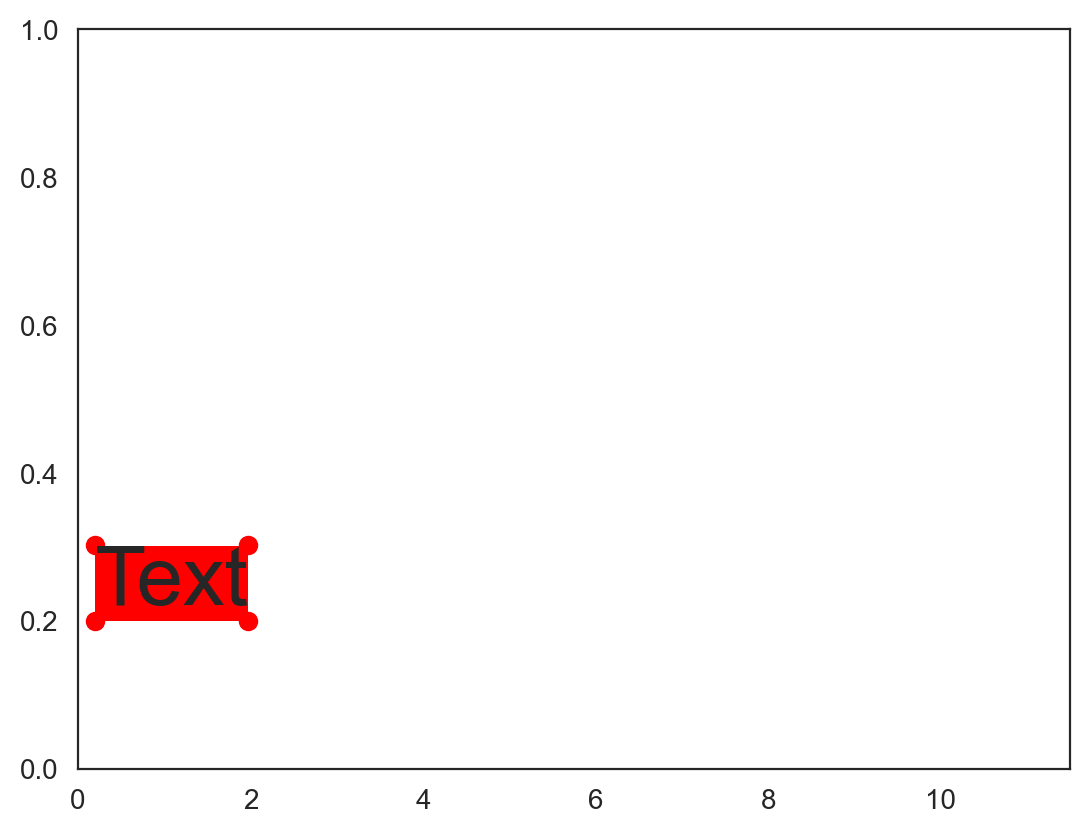

In [566]:
fig, ax = plt.subplots()
plt.xlim(0, 0.5)
plt.ylim(0, 1)
t = ax.text(0.2, 0.2, 'Text', fontsize=30, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=0, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))


transf = ax.transData.inverted()
bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
bbt = bb.transformed(transf)
coords = bbt.get_points()
print(coords)
(x0, y0), (x1, y1) = coords
plt_coords = np.array([(x0, y0), (x0, y1), (x1, y1), (x1, y0)])

ax.scatter(*plt_coords.T, c='red')



[[0.1        0.1       ]
 [0.25716788 0.0862437 ]]
[[0.1        0.23      ]
 [0.25716788 0.2162437 ]]


AttributeError: 'NoneType' object has no attribute 'get_points'

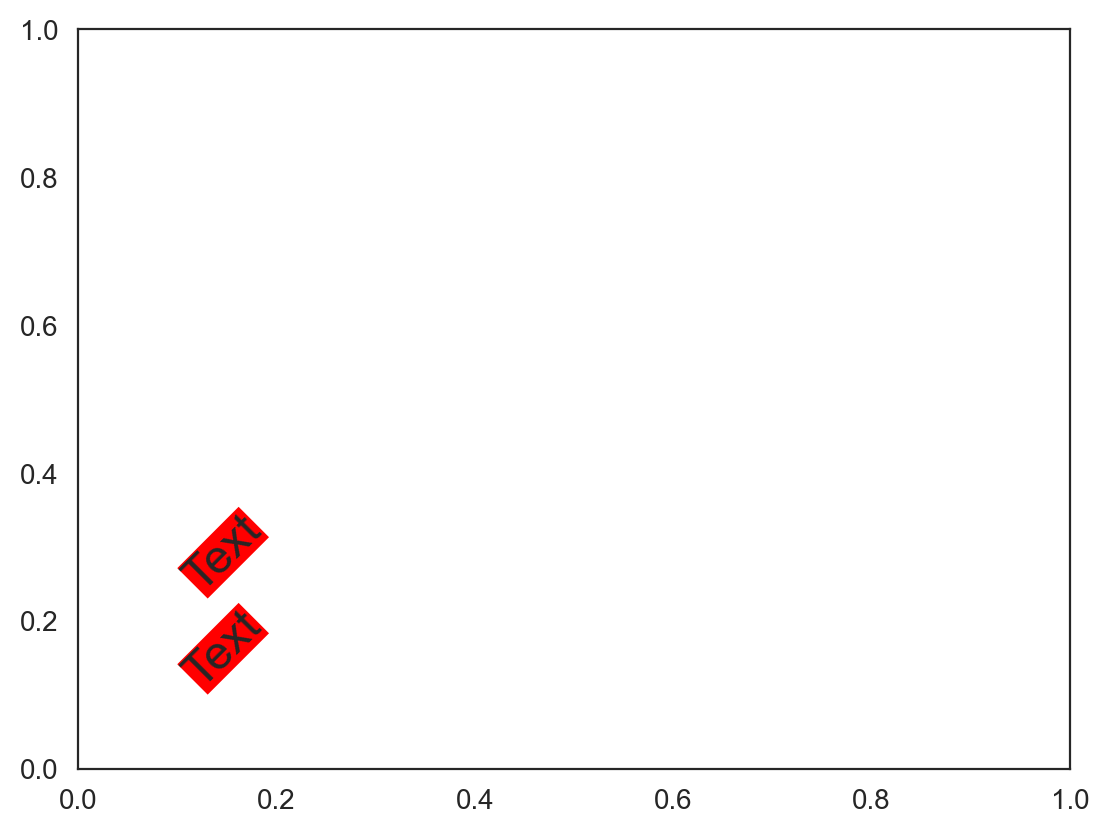

In [391]:
import matplotlib.transforms

from matplotlib.transforms import Bbox
fig, ax = plt.subplots()

def get_polygon(t):

    transf = ax.transData.inverted()
    bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
    bbt = bb.transformed(transf)
    coords = bbt.get_points()

    x0, y0 = coords[0]
    trafo = matplotlib.transforms.Affine2D().rotate_around(x0,y0,-)
    print(trafo.transform(coords))

# bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
    # coords = bb.get_points()
    # print(coords)
    # x0, y0 = coords[0]
    # print(x0, y0)
    # trafo = matplotlib.transforms.Affine2D().rotate_around(x0,y0,45)

    # coords = bb.get_points()
    # print(coords)
    # print(trafo.transform(coords))

    # transf = ax.transData.inverted()
    # bb = t.get_window_extent(renderer = fig.canvas.get_renderer())
    # bbt = bb.transformed(transf)
    # # return bbt
    # b = bbt.bounds
    # # print(dir(bbt), bbt.rotated(0.785398).corners())

    # return Polygon([Point(b[0], b[1]), Point(bbt.xmin, b[1]+(b[0]-bbt.xmin)), Point(b[2], b[3]), Point(bbt.xmax, b[3]-(b[0]-bbt.xmin))])
    # # return Polygon([Point(bbt.xmin, bbt.ymin), Point(bbt.xmin, bbt.ymin), Point(bbt.xmin, bbt.ymin), Point(bbt.xmin, bbt.ymin)])

t = ax.text(0.1, 0.1, 'Text', fontsize=17, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=45, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))
a = get_polygon(t)
#xs, ys = zip(*[(p.x, p.y) for p in a.get_points()])
# print(xs, ys)

t = ax.text(0.1, 0.23, 'Text', fontsize=17, horizontalalignment='left',# weight='bold',
                         verticalalignment='bottom', rotation=45, zorder=3, bbox=dict(boxstyle='square,pad=0', fc='red', ec='none'))
#ax.plot(xs,ys) 
b = get_polygon(t)
is_polygons_intersecting(a, b)

#print(Bbox.intersection(a, b))

Bbox(x0=72266463.49999999, y0=2.299999999999999, x1=78844788.63027559, y1=4.219218090860526)
Bbox(x0=38185129.999999985, y0=2.299999999999999, x1=43874492.27483292, y1=3.959864294798294)
Bbox(x0=2916660.500000015, y0=2.299999999999999, x1=8677139.803268358, y1=3.9806125984832725)
Bbox(x0=1428450.5, y0=2.299999999999999, x1=8042334.144493267, y1=4.229592242703012)
Bbox(x0=44533249.000000015, y0=2.299999999999999, x1=52320563.613677576, y1=4.571939253505164)
Bbox(x0=6908011.500000015, y0=2.299999999999999, x1=12632932.289050654, y1=3.9702384466407814)
Bbox(x0=53064702.000000015, y0=2.299999999999999, x1=60531989.985718235, y1=4.478571886922758)
Bbox(x0=119654546.99999999, y0=2.299999999999999, x1=127619654.1847661, y1=4.623810012717609)
Bbox(x0=48684013.500000015, y0=2.299999999999999, x1=53626646.976261124, y1=3.7420071061060156)
Bbox(x0=15840368.500000015, y0=2.299999999999999, x1=22169784.03075163, y1=4.146599027963099)
Bbox(x0=16742475.999999985, y0=2.299999999999999, x1=23107450.044

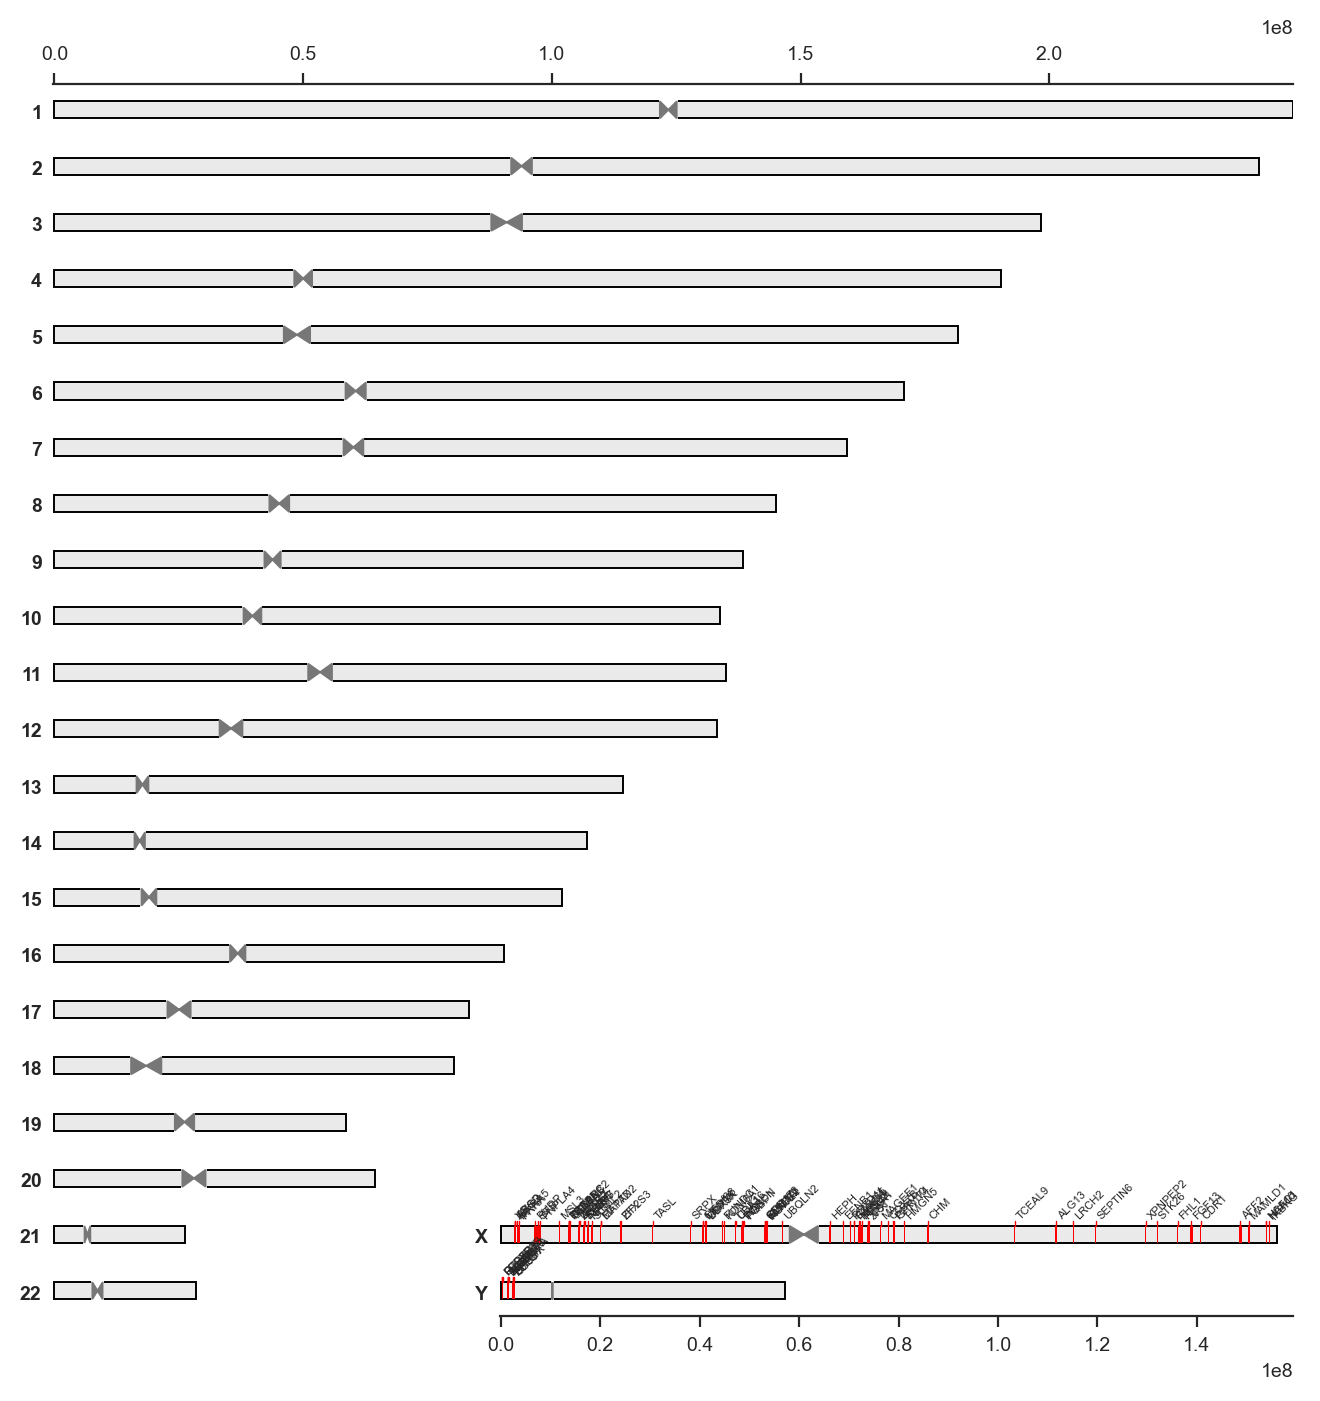

In [24]:
import importlib
import geneinfo
importlib.reload(geneinfo)

gi.chrom_ideogram(annotation, figsize=(8, 8))